# 

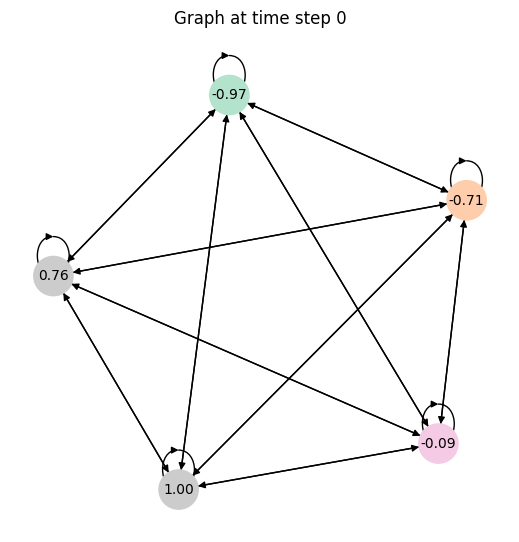

In [35]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

def visualize_graph(data: Data, t: int = 0):
    G = to_networkx(data)
    x = data.x[0, t, :, 0].numpy()
    pos = nx.spring_layout(G, seed=42)

    fig = plt.figure(figsize=(5, 5))
    nx.draw(G, pos, node_color=x, cmap='Pastel2', node_size=800)
    
    labels = {i: f"{y:.2f}" for i, y in enumerate(x)}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
    
    fig.gca().set_title(f"Graph at time step {t}")

def generate_temporal_graphs(
    graphs: int,
    cycles: float = 1.0, 
    std: float = 0.0,
    steps_per_cycle: int = 64,
    num_nodes: int = 5,
): 
    S = int(cycles * steps_per_cycle)
    t = torch.linspace(0, cycles, S)
    X = torch.zeros((graphs, S, num_nodes, 1))
    
    T = t[None, :, None, None]
    T = T * (torch.rand((graphs, 1, 1, 1)) * 0.5 + 1)
    T = T + torch.rand((graphs, 1, num_nodes, 1))
    
    X = torch.sin(T * 2 * torch.pi) + torch.randn_like(T) * std
    
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    self_loops = torch.arange(num_nodes).unsqueeze(0).repeat(2,1)
    edge_index = torch.cat([edge_index, edge_index.flip(0), self_loops], dim=1)
    edge_weight = torch.ones(edge_index.size(1))
    data = Data(x=X.to(torch.float32), edge_index=edge_index, edge_weight=edge_weight)
    return data, T

visualize_graph(generate_temporal_graphs(graphs=1)[0])

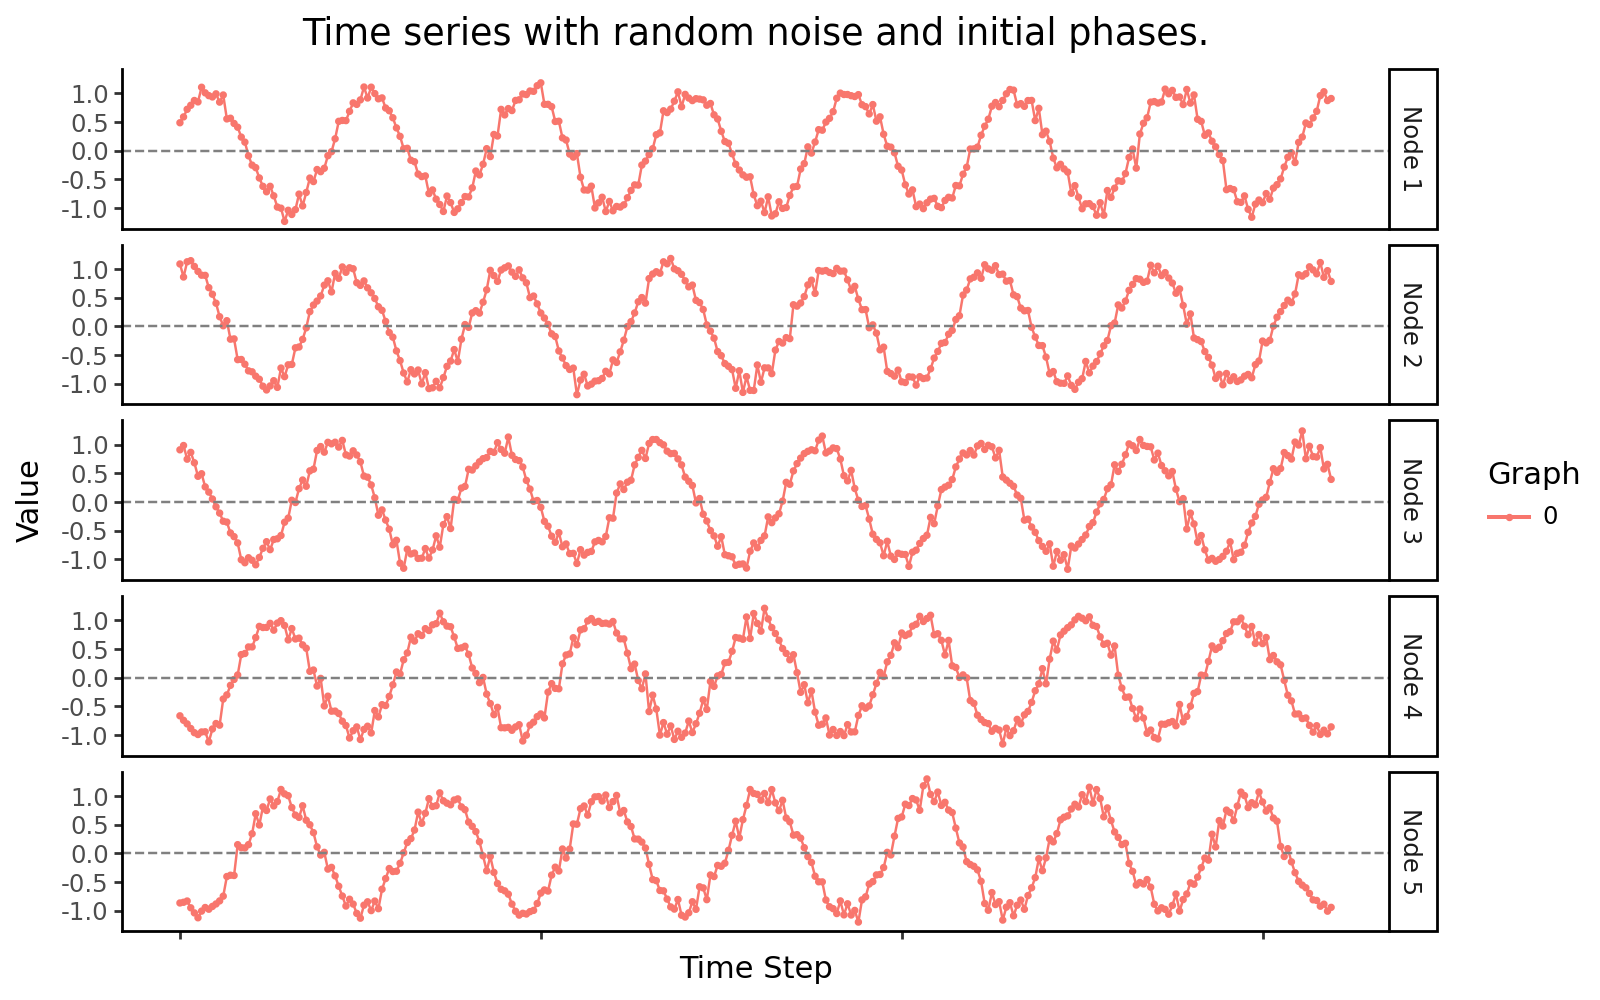

In [36]:
import pandas as pd
from plotnine import *

def show_graph_time_series(data: Data):
    X = data.x.transpose(1, 2).squeeze(-1).numpy()

    graphs, nodes, steps = X.shape
    T = np.tile(np.arange(steps), graphs * nodes)
    N = np.tile(np.repeat(np.arange(nodes), steps), graphs)
    G = np.repeat(np.arange(graphs), nodes * steps)
    df = pd.DataFrame({
        'Time Step': T,
        'Node': [f'Node {n+1}' for n in N],
        'Graph': list(map(str, G)),
        'Value': X.reshape(-1)
    })

    return (ggplot(df, aes(x='Time Step', y='Value', color='Graph')) 
        + facet_grid('Node ~ .')
        + geom_line(aes(group='Graph'))
        + geom_point(size=0.5)
        + geom_hline(yintercept=0, color='gray', linetype='dashed')
        + theme_classic()
        + theme(axis_text_x=element_blank(), figure_size=(8, 5)))

data, _ = generate_temporal_graphs(graphs=1, cycles=5, std=0.1)
show_graph_time_series(data) + ggtitle(f'Time series with random noise and initial phases.')

In [49]:
from torch_geometric_temporal import BatchedDCRNN
from tqdm.notebook import tqdm
from torch import nn

def train(data: Data, val_data: Data, num_epochs, emb_dim, K=1):
    B, S, N, D = data.x.shape
    assert S % 2 == 0

    encoder = BatchedDCRNN(in_channels=1, out_channels=emb_dim, K=K)
    decoder = nn.Linear(emb_dim * S // 2 * D, S // 2)
    
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.01)

    bar = tqdm(range(num_epochs))
    X, X_val = data.x[:, :S//2], val_data.x[:, :S//2]
    y, y_val = data.x[:, S//2:], val_data.x[:, S//2:]

    for _ in bar:
        encoder.train()
        
        emb = encoder(X, edge_index=data.edge_index, edge_weight=data.edge_weight)
        emb = emb.transpose(1, 2).reshape(B, N, -1)
        
        y_pred = decoder(emb).transpose(1, 2).unsqueeze(-1)
    
        loss = torch.nn.functional.mse_loss(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        encoder.eval()
        
        with torch.no_grad():
            val_emb = encoder(X_val, edge_index=val_data.edge_index, edge_weight=val_data.edge_weight)
            val_emb = val_emb.transpose(1, 2).reshape(X_val.size(0), N, -1)
            y_val_pred = decoder(val_emb).transpose(1, 2).unsqueeze(-1)
            val_loss = torch.nn.functional.mse_loss(y_val_pred, y_val)
        
        bar.set_description(f'Loss: {val_loss.item():.4f}')
        
    return encoder, decoder

data, _ = generate_temporal_graphs(graphs=32, cycles=0.25, std=0.2)
val_data, _ = generate_temporal_graphs(graphs=8, cycles=0.25, std=0.0)
encoder, decoder = train(data, val_data, num_epochs=100, emb_dim=2, K=2)

  0%|          | 0/100 [00:00<?, ?it/s]

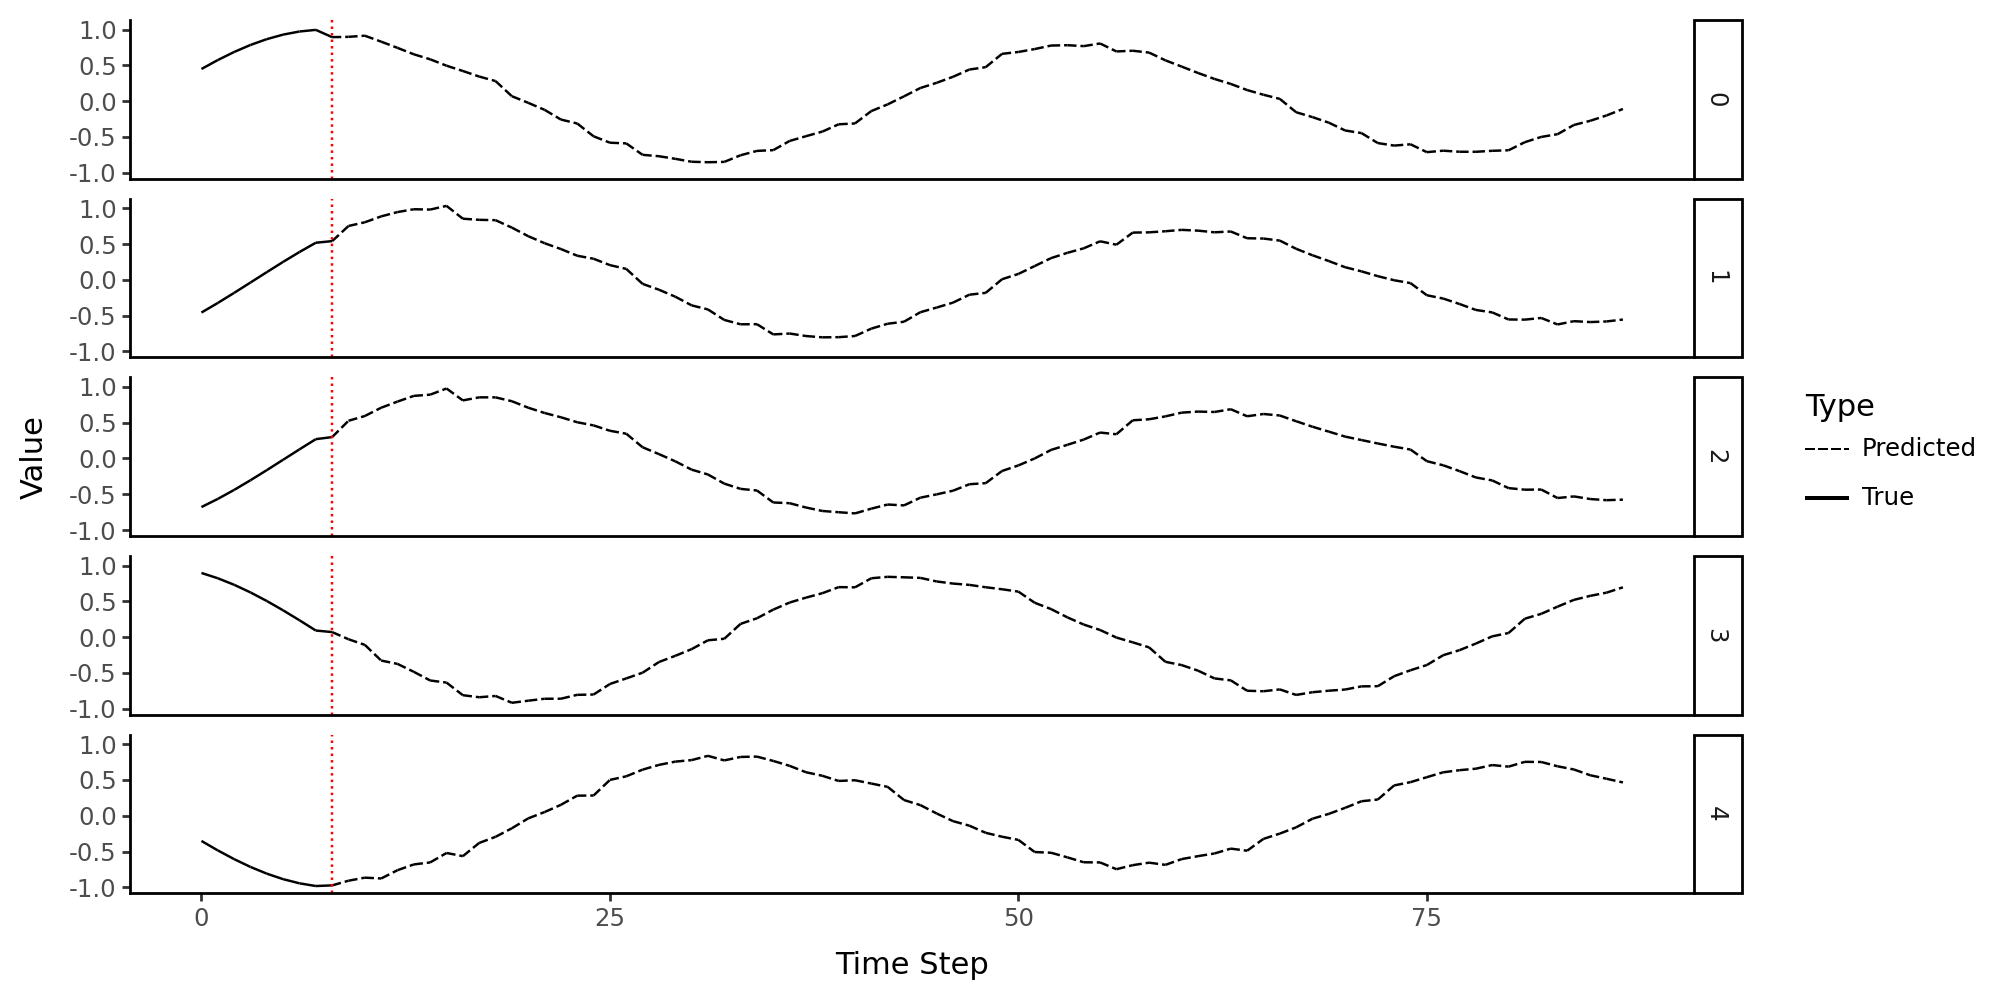

In [50]:
def visualize_autoreg_results(df: pd.DataFrame, steps: int):
    return (ggplot(df, aes(x='Time Step', y='Value', group='Node', linetype='Type'))
        + facet_grid('Node ~ .')
        + geom_line(size=0.5)
        + geom_vline(xintercept=steps, linetype='dotted', color='RED')
        + scale_linetype_manual(values=['dashed', 'solid'])
        + theme_classic() + theme(figure_size=(10, 5))
    )

def predict_autoreg(
    encoder, 
    decoder, 
    data: Data, 
    n_times: int = 1
):
    B, S, N, D = data.x.shape
        
    X = data.x        
    y = np.zeros((B, N, 0))
    
    for _ in range(n_times):
        emb = encoder(X, edge_index=data.edge_index, edge_weight=data.edge_weight)
        emb = emb.transpose(1, 2).reshape(B, N, -1)
        
        y_pred = decoder(emb).transpose(1, 2).detach()
        
        y = np.concatenate([y, y_pred.transpose(1, 2)], axis=2)
        X = y_pred.unsqueeze(-1)
    
    x = data.x[:, :, :, 0].detach().numpy().transpose(0, 2, 1)
    xy = np.concatenate([x, y], axis=2)
    return xy

graph, _ = generate_temporal_graphs(graphs=1, cycles=0.125, std=0.0)
xy = predict_autoreg(encoder, decoder, graph, n_times=10)[0, :, :]

labels = ['True'] * graph.x.shape[1] + ['Predicted'] * (xy.shape[1] - graph.x.shape[1])
df = pd.DataFrame({
    'Time Step': np.tile(np.arange(xy.shape[1]), xy.shape[0]),
    'Node': np.repeat(np.arange(xy.shape[0]), xy.shape[1]),
    'Value': xy.reshape(-1).tolist(),
    'Type': np.tile(labels, xy.shape[0]),
})

visualize_autoreg_results(df, steps=graph.x.shape[1])

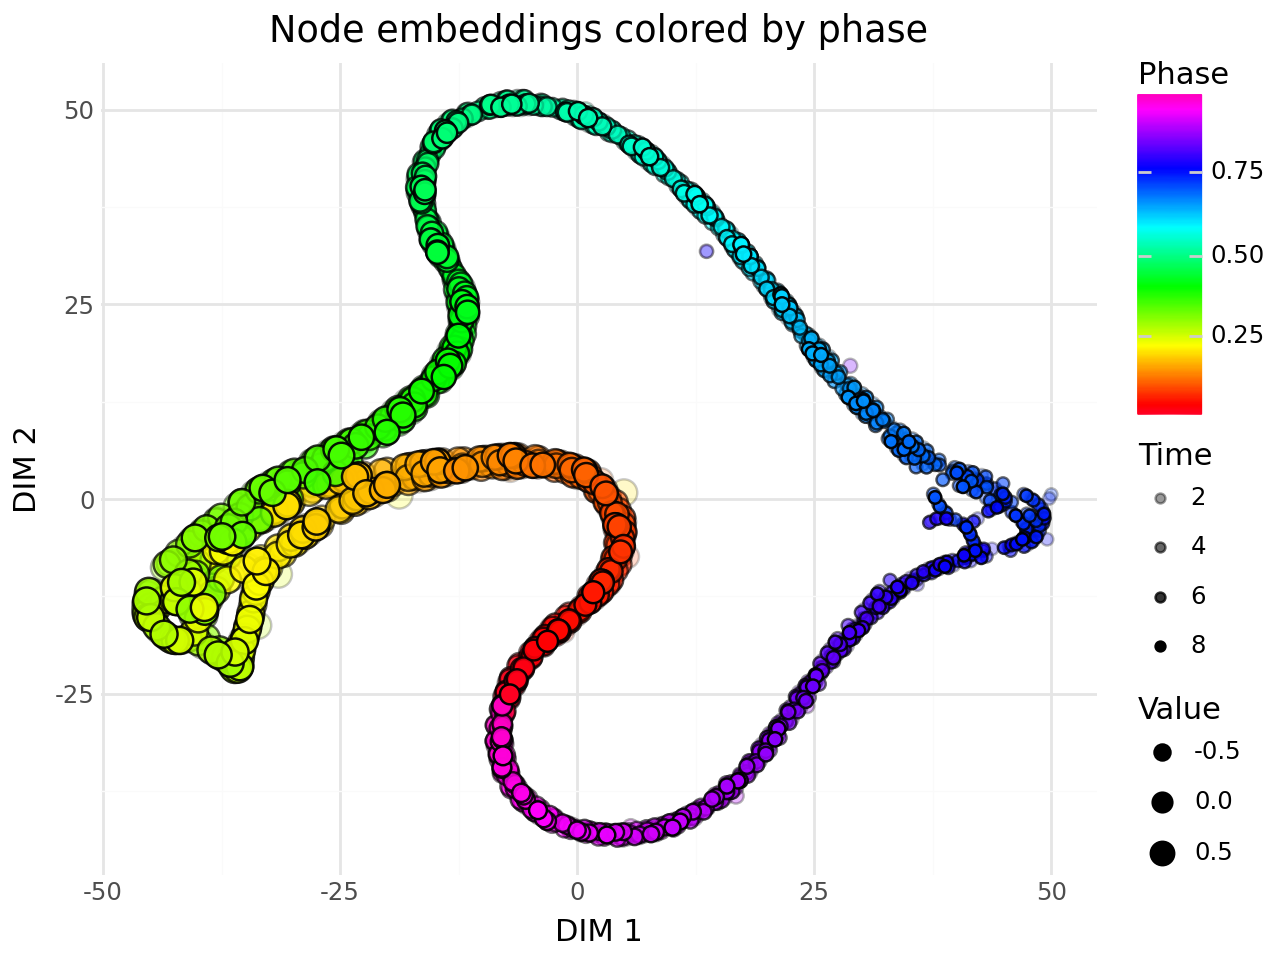

In [58]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualize_tsne(encoder, data, T, type_ = None):
    encoder.eval()
    emb = encoder(data.x, edge_index=data.edge_index, edge_weight=data.edge_weight)
    emb = emb.detach().squeeze(0).numpy()
    emb = emb.reshape(-1, emb.shape[-1])

    emb_2d = TSNE(n_components=2).fit_transform(emb)
    # emb_2d = PCA(n_components=2).fit_transform(emb)

    df = pd.DataFrame({
        'DIM 1': emb_2d[:, 0], 
        'DIM 2': emb_2d[:, 1],
        'Value': data.x.view(-1).numpy(),
        'Time': T.view(-1).numpy(),
        'Phase': T.view(-1).numpy() % 1,
        'Graph': np.repeat(np.arange(data.x.size(0)), data.x.size(1) * data.x.size(2)),
    })
    
    if type_ is not None:
        df['Type'] = type_    
        
    p = (ggplot(df, aes(x='DIM 1', y='DIM 2', size='Value', fill='Phase', alpha='Time')) 
        + geom_point()
        + scale_fill_continuous(cmap_name='gist_rainbow')
        + scale_alpha(range=(0.2, 1.0))
        + scale_size_radius(range=(2, 5))
        + theme_minimal()
        + ggtitle('Node embeddings colored by phase'))
            
    if type_ is not None:
        p += aes(shape='Type')
        p += scale_shape_manual(values={False: 'o', True: '^'})
        
    return p
        
val_data, T = generate_temporal_graphs(graphs=1, cycles=5, std=0.0)
visualize_tsne(encoder, val_data, T)

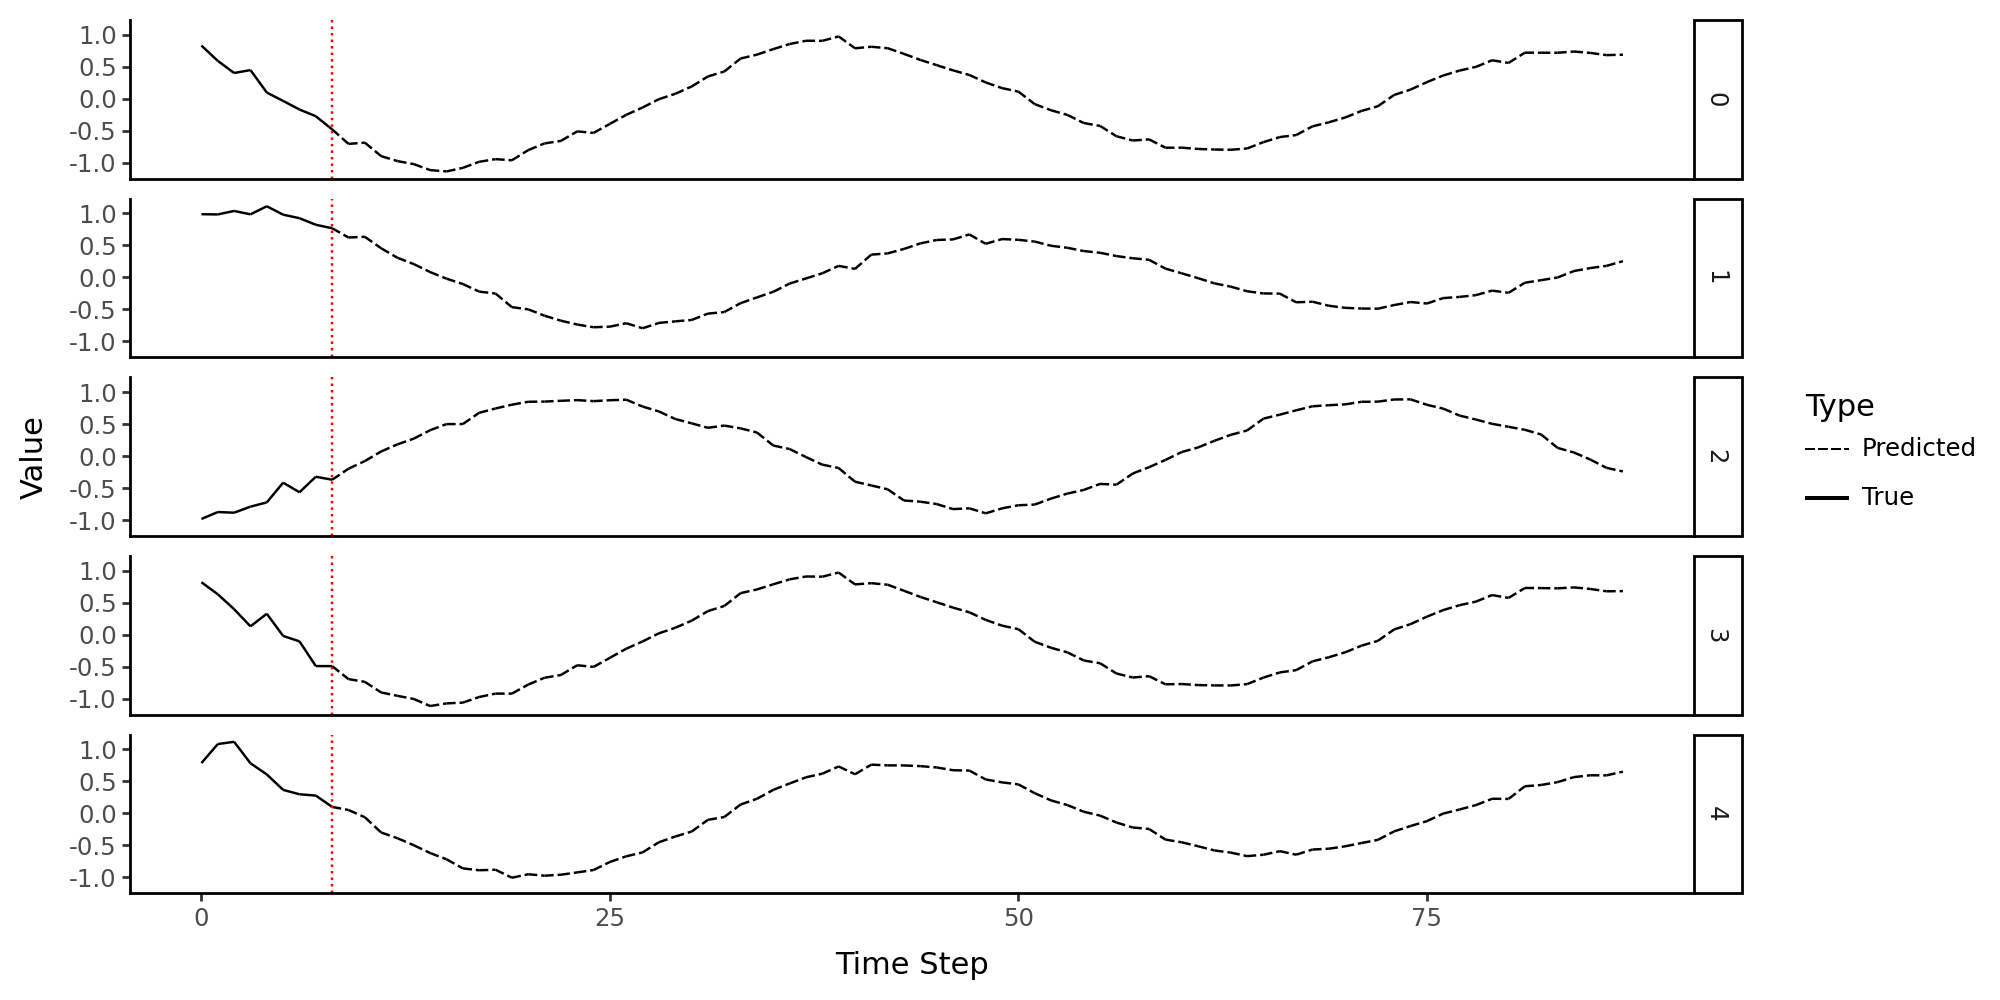

In [56]:
graph = generate_temporal_graphs(graphs=5, cycles=0.125, std=0.1)[0]
# graph.x[:, -1:, :, :] = 0
xy = predict_autoreg(encoder, decoder, graph, n_times=10)[0, :, :]

labels = ['True'] * graph.x.shape[1] + ['Predicted'] * (xy.shape[1] - graph.x.shape[1])

df = pd.DataFrame({
    'Time Step': np.tile(np.arange(xy.shape[1]), xy.shape[0]),
    'Node': np.repeat(np.arange(xy.shape[0]), xy.shape[1]),
    'Value': xy.reshape(-1).tolist(),
    'Type': np.tile(labels, xy.shape[0]),
})

visualize_autoreg_results(df, steps=graph.x.shape[1])